# Donorchose.org empowers public school teachers from across the country to request much-needed materials and experiences for their students.
At any given time, there are thousands of classroom requests that can be brought to life with a gift of any amount.

In this notebook we solve the problem whether the teacher gets the approval or not.


Business constraints:
1.No latency issue
2.AUC as the metric(as imbalanced dataset)


Categorical features feature extraction

In [96]:
#Using only one hot encoding (Countvectorizer) and
#Response Coding

In [97]:
#dividing the whole data into train,cv and test as Xtrain,Xcv and Xtest

In [98]:
y=df['project_is_approved']
Xtrain=df.iloc[0:116532,:]
Xcv=df.iloc[116532:145664,:]
Xtest=df.iloc[145664:,:]


y_train=y[0:116532]
y_cv=y[116532:145664]
y_test=y[145664:]

In [99]:
##Code for response coding

In [100]:
#Response coding dictionary
def get_rs_fea_dict(alpha, df,feature):
    
    value_count = Xtrain[feature].value_counts()
    rs_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 2 diamensional vector
        vec = []
        for k in range(0,2):
            

            cls_cnt =Xtrain.loc[(Xtrain['project_is_approved']==k) & (Xtrain[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 20*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        rs_dict[i]=vec
    return rs_dict

# Get Resonse Coding feature
def Res_feature(alpha,df, feature):
    
    rs_dict = get_rs_fea_dict(alpha,df, feature)
    
    value_count = Xtrain[feature].value_counts()
    
    
    Rs_fea = []
   
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            Rs_fea.append(rs_dict[row[feature]])
        else:
            Rs_fea.append([1/2,1/2])
#             
    return Rs_fea

In [101]:
X_1 =np.array(Res_feature(1,Xtrain, 'teacher_prefix'))
X_2 = np.array(Res_feature(1,Xtrain, 'school_state'))
X_3 = np.array(Res_feature(1,Xtrain, 'project_grade_category'))
X_4 =np.array( Res_feature(1,Xtrain, 'project_subject_categories'))
X_5 =np.array( Res_feature(1,Xtrain, 'project_subject_subcategories'))

cattrain =np.hstack((X_1, X_2, X_3, X_4, X_5))


In [102]:
X_1 =np.array(Res_feature(1,Xcv, 'teacher_prefix'))
X_2 = np.array(Res_feature(1,Xcv, 'school_state'))
X_3 = np.array(Res_feature(1,Xcv, 'project_grade_category'))
X_4 =np.array( Res_feature(1,Xcv, 'project_subject_categories'))
X_5 =np.array( Res_feature(1,Xcv, 'project_subject_subcategories'))

catcv = np.hstack((X_1, X_2, X_3, X_4, X_5))

In [103]:
X_1 =np.array(Res_feature(1,Xtest, 'teacher_prefix'))
X_2 = np.array(Res_feature(1,Xtest, 'school_state'))
X_3 = np.array(Res_feature(1,Xtest, 'project_grade_category'))
X_4 =np.array( Res_feature(1,Xtest, 'project_subject_categories'))
X_5 =np.array( Res_feature(1,Xtest, 'project_subject_subcategories'))

cattest =np.hstack((X_1, X_2, X_3, X_4, X_5))

In [ ]:
# This is the code for One hot encoding

In [ ]:
def getCatFeatures(df, Col):
    vectorizer = CountVectorizer(binary=True,
                                 ngram_range=(1,1),
                                 tokenizer=lambda x:[a.strip() for a in x.split(',')]) #why strip() is imp here?
    vectorizer.fit(df[Col])
   # return vectorizer.get_feature_names()

In [ ]:
X_tp = getCatFeatures(Xcv, 'teacher_prefix')
X_ss = getCatFeatures(Xcv, 'school_state')
X_pgc = getCatFeatures(Xcv, 'project_grade_category')
X_psc = getCatFeatures(Xcv, 'project_subject_categories')
X_pssc = getCatFeatures(Xcv, 'project_subject_subcategories')

#catcv = hstack((X_tp, X_ss, X_pgc, X_psc, X_pssc))


In [73]:
X_tp = getCatFeatures(Xtest, 'teacher_prefix')
X_ss = getCatFeatures(Xtest, 'school_state')
X_pgc = getCatFeatures(Xtest, 'project_grade_category')
X_psc = getCatFeatures(Xtest, 'project_subject_categories')
X_pssc = getCatFeatures(Xtest, 'project_subject_subcategories')

#cattest = hstack((X_tp, X_ss, X_pgc, X_psc, X_pssc))


In [233]:
cattrain.shape##100 featues 

(116532, 10)

In [423]:
##Applying Logistic Regression to only Response Coded features

In [104]:

alpha = [10 ** j for j in range(-5,1)] # hyperparam for SGD classifier.

cv_auc_array=[]
for i in alpha:
    clf = LogisticRegression(C=i, penalty='l2', random_state=42,class_weight='balanced')
    clf.fit(cattrain, y_train)
    predict_y = clf.predict_proba(catcv)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_cv,predict_y )
    cv_auc_array.append(metrics.auc(fpr, tpr))
    print('For values of alpha = ', i, "The AUC is:",metrics.auc(fpr, tpr))


For values of alpha =  1e-05 The AUC is: 0.5495038374662762
For values of alpha =  0.0001 The AUC is: 0.5489625415244448
For values of alpha =  0.001 The AUC is: 0.5490703539627738
For values of alpha =  0.01 The AUC is: 0.550434398369883
For values of alpha =  0.1 The AUC is: 0.5539850025624028
For values of alpha =  1 The AUC is: 0.5549472341588653


In [105]:
clf =LogisticRegression(C=1, penalty='l2', random_state=42,class_weight='balanced')
clf.fit(cattrain, y_train)

predict_y = clf.predict_proba(cattrain)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_train,predict_y )
print('For values of best alpha = ',"The train AUC is:",metrics.auc(fpr, tpr))

predict_y = clf.predict_proba(catcv)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_cv,predict_y )
print('For values of best alpha = ', "The cv AUC is:",metrics.auc(fpr, tpr))

predict_y = clf.predict_proba(cattest)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,predict_y )
print('For values of best alpha = ', "The test AUC is:",metrics.auc(fpr, tpr))


For values of best alpha =  The train AUC is: 0.5727882990935408
For values of best alpha =  The cv AUC is: 0.5549472341588653
For values of best alpha =  The test AUC is: 0.5748796095843418


In [106]:
###Definitely categorical features needs to be added to the final model

ID and Teacher ID

In [107]:
#Id and teacherID 
#no of previously applied feature is correlated with y,we can directly use this feature

In [108]:
df['id'][0:5]

128730    p146022
173035    p244738
7344      p070708
180523    p083729
8393      p205479
Name: id, dtype: object

In [109]:
df['teacher_id'][0:5]

128730    f91a89d2b72a0f5ee14cd98bd8741fc2
173035    64ef8a335f7206366c52c39f5bfd09b7
7344      1f802ff6be7973fb3624332e10549ed4
180523    f72fac3c6011b17ad5b2037dfd18cd0b
8393      2bf07ba08945e5d8b2a3f269b2b3cfe5
Name: teacher_id, dtype: object

In [ ]:
df['teacher_id']=le.fit_transform(df['id'])

In [ ]:
le = LabelEncoder()
le.fit(Xtrain['id'])
idtrain=le.transform(Xtrain['id'])
idcv=le.transform(Xcv['id'])
idtest=le.transform(Xtest['id'])

In [ ]:
##Label encoder is not helping 

In [ ]:
TEXT FEATUES

In [90]:
# shifting 2nd essay text to 4th essay if that is empty
#then combining 1st and 2nd ,3rd and 4th essays

In [111]:
# 
df.loc[df['project_essay_4'].isnull(),['project_essay_2','project_essay_4']] =df.loc[df['project_essay_4'].isnull(),['project_essay_4','project_essay_2']].values

In [112]:
df['project_essay_2'][0:2]

128730    My students can vary quite dramatically. I hav...
173035    Welcome to our Pre-K classroom. We work hard e...
Name: project_essay_2, dtype: object

In [113]:
df[['project_essay_2','project_essay_3']] = df[['project_essay_2','project_essay_3']].fillna('')
df['project_essay_1'] = df.apply(lambda row: ' '.join([str(row['project_essay_1']), 
                                                     str(row['project_essay_2'])]), axis=1)
df['project_essay_2'] = df.apply(lambda row: ' '.join([str(row['project_essay_3']),
                                                     str(row['project_essay_4'])]), axis=1)

df = df.drop(['project_essay_3', 'project_essay_4'], axis=1)


In [114]:
df['project_essay_1'].values[2]

'Our classroom is an engaging, vibrant, and diverse community that strives to create an inclusive learning environment for all students! It\'s a bright and busy place with high learning expectations, technology, and Common Core Math/English Language Arts and the center of it all! My students are learning to become strong, independent, critical thinkers while also transitioning into responsible and respectful members of our community. The students in my classroom are young but with structure, guidance, engaging lessons, and hands-on activities anything is possible! My students are at the beginning of their educational careers and it is my goal to provide them with  positive opportunities and experiences with core content areas such as Math, Reading, Science, Social Studies, and Technology in order to foster a curiosity and love of learning! \\r\\n\\r\\nThe school community we are part of is an \\"Inclusion Community\\" that provides the least restrictive environment for all students and

In [115]:
##\\r\\n\\r\\n---so preprocessing must be done on the text 

In [116]:
df['project_essay_2'].values[1]

"This time, I am asking to improve three different centers. My students are bilingual and it is very difficult to find appropriate Spanish books for emergent readers. I am sure my students, who are ready to read, will benefit from these books. I will work in small group to help them improve their reading skills. Also, the Monkey Letters are to spell out sight words and even for them to create words on their own. My other two centers are math and construction. Math can be integrated in construction to make it more education for the students, but at the same time they are learning and enjoying it. Building by following instructions is favorable for young children to learn to how to listen. Soft Blocks are perfect for preschoolers; these block are safe and colorful to catch their attention. The Ten Frame class set will be perfect to work with addition and counting. Everything will be used for the development of my students' education and to be ready for Kindergarten. This project will hav

In [117]:
##Speling mistakes are there---(environment)
# It will be good to have a feature of no of spelling mistakes
# Also we should correct the mistakes to make our analysis better

In [118]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from autocorrect import spell
spell('TGhe')

'The'

In [119]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", 
                    "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", 
                    "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", 
                    "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
                    "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have",
                    "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", 
                    "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                    "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not",
                    "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                    "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                    "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have",
                    "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is",
                    "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                    "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", 
                    "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will",
                    "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", 
                    "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is",
                    "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                    "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                    "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", 
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                    "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
                    "y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                    "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)



In [120]:
df['resource_description']=df['resource_description'].astype(str)
stop=set(stopwords.words('english'))

In [121]:
def clean_text(text):
    tokens = word_tokenize(text)
# remove all tokens that are not alphabetic
    words = [word for word in tokens if word.isalpha() ]
    return words

In [122]:
#lowering
def preprocess(df):
    df=df.apply(lambda x:clean_text(x)) # removing punctuations
    df=df.apply(lambda x:" ".join(word.lower() for word in x if word not in stop))
    df = df.apply(lambda x: replace_contractions(x))
    #df['text1']=df['text1'].apply(lambda x: str(TextBlob(x).correct()))  ## taking a lot of time
    #df=df.apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
    return df

In [123]:
df['text0']=preprocess(df['project_essay_1'])

In [124]:
df['project_essay_1'][3]

'My students are the greatest students but are socially and economically disadvantaged.  We are an inner city school being limited to doing all activities in (PE) Physical Education inside because we have violence at the location where our school is located.  All the physical activities the students are active with are within the school so we have to have a good program.\\r\\n\\r\\nMost of the students are either African American or Hispanic.  The students range from being enrolled as a kindergarten-8th grade.  Since Physical Education is important with one\'s success in school; all the students have PE class Monday through Friday every day.  The proper equipment in PE is not always possible so this is why we are here asking for your help with shelving.\\r\\n\\r\\nThis project is \\"kid-inspired\\" in that they want better fitness.  They look back at their PE class and said that is only 30 minutes each day.  They go to an extended day school year-round school which after 3:00 in the af

In [125]:
df['text0'][3] ##preprocessed text

'my students greatest students socially economically disadvantaged we inner city school limited activities pe physical education inside violence location school located all physical activities students active within school good students either african american hispanic the students range enrolled grade since physical education important one success school students pe class monday friday every day the proper equipment pe always possible asking help project want better fitness they look back pe class said minutes day they go extended day school school afternoon minutes physical activity they said need equipment active the students kid want variety equipment life changing physical activity'

In [126]:
df['text1']=preprocess(df['project_essay_2'])
df['text2']=preprocess(df['project_resource_summary'])
df['text3']=preprocess(df['project_title'])
df['text4']=preprocess(df['resource_description'])

In [127]:
## lets see some wordcloud for the rejected and accepted essays

In [128]:
x=df[df['project_is_approved']==1]
y=df[df['project_is_approved']==0]

In [130]:
x['text0'][0]

'most kindergarten students come households considered these kids walk school alongside parents never walking distance house for students english first language language spoken home kindergarten kids many obstacles front come school day excited ready learn most students started year never school setting at start year many never exposed letters each day soak knowledge try hardest succeed they highly motivated learn new things every day we halfway year starting take they know know letters sight words numbers majority letter sounds hard work determination i excited see places go'

In [131]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)


def wordcloud(text,heading):
    text =str(text)
# Create and generate a word cloud image:
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

# Display the generated image:
    fig = plt.figure(figsize=(10,10))
    
    plt.xlabel(heading)
    plt.imshow(wordcloud, interpolation='bilinear')
    
    plt.show()

   

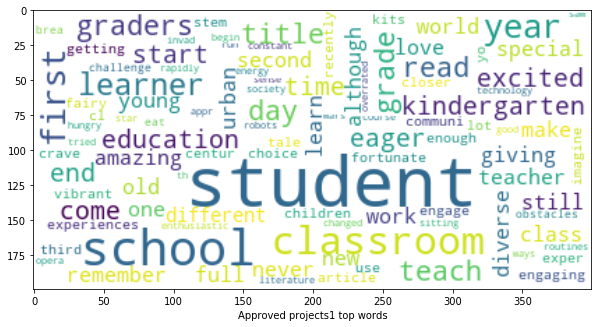

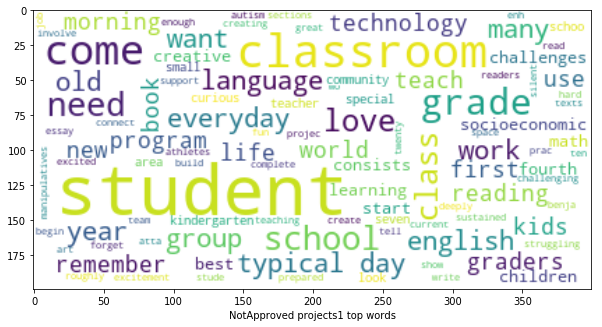

In [132]:
wordcloud(x['text0'],'Approved projects1 top words')
wordcloud(y['text0'],'NotApproved projects1 top words')

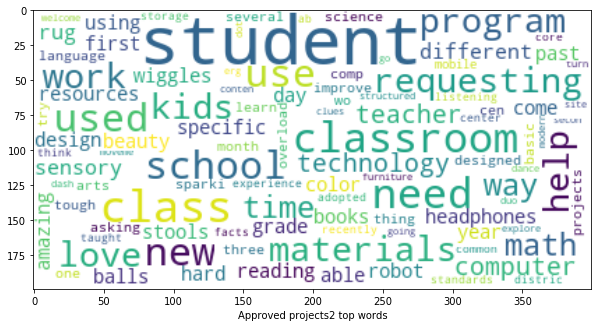

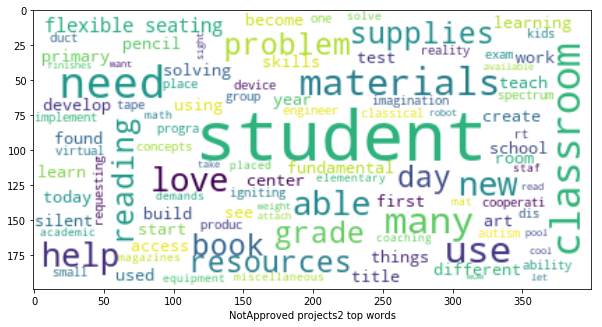

In [133]:
wordcloud(x['text1'],'Approved projects2 top words')
wordcloud(y['text1'],'NotApproved projects2 top words')

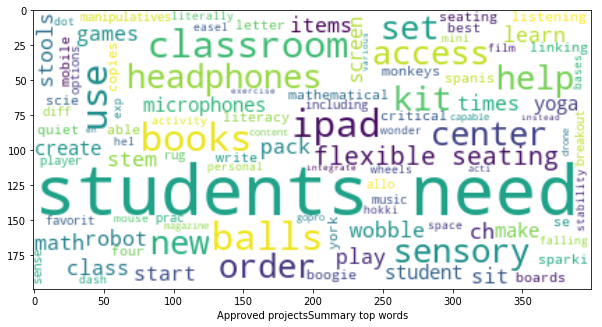

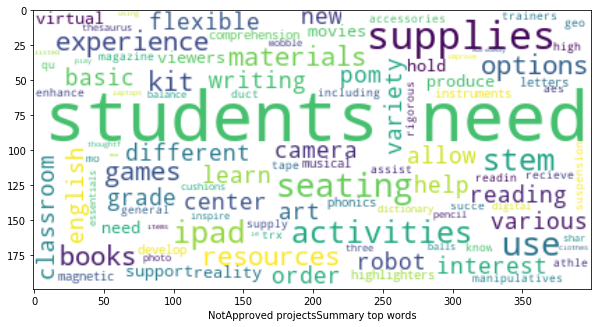

In [134]:
wordcloud(x['text2'],'Approved projectsSummary top words')
wordcloud(y['text2'],'NotApproved projectsSummary top words')

In [135]:
##We conclude there is not much we can understand which words are given importances
#We can use TF-IDF and COuntvectorizer for this data and see for which give the highest performance in the final model


In [136]:
#Rather than combining all the text it will be much better to take different texts and generate Vectors and then combine each
#of them

In [140]:
#We can use ngrams as (1,2) to capture the text 
#There is no much difference if use trigrams as well

In [168]:
Xtrain=df.iloc[0:116532,:]
Xcv=df.iloc[116532:145664,:]
Xtest=df.iloc[145664:,:]


y=df['project_is_approved']

y_train=y[0:116532]
y_cv=y[116532:145664]
y_test=y[145664:]

In [169]:
Xtrain.shape

(116532, 39)

In [170]:
y_train.shape

(116532,)

In [156]:
def TextFeatures(df, Col,ngrams=(1,2),max_features=10000, verbose=True):


    vectorizer = CountVectorizer(min_df=3, max_features=max_features)
    vectorizer.fit(Xtrain[Col])
    X=vectorizer.transform(df[Col])
    return X, vectorizer.get_feature_names()

In [157]:
n1, n2, n3, n4, n5 = 8000, 8000, 2000, 3000, 1000
X_1, feat1 = TextFeatures(Xtrain, 'text0', max_features=n1)
X_2, feat2 = TextFeatures(Xtrain, 'text1', max_features=n2)
X_3, feat3 = TextFeatures(Xtrain, 'text2', max_features=n3)
X_4, feat4 = TextFeatures(Xtrain, 'text4', max_features=n4)
X_5, feat5= TextFeatures(Xtrain, 'text3', max_features=n5)

Xtexttrain = hstack((X_1, X_2, X_3, X_4, X_5))

In [158]:

X_1, feat1 = TextFeatures(Xcv, 'text0', max_features=n1)
X_2, feat2 = TextFeatures(Xcv, 'text1', max_features=n2)
X_3, feat3 = TextFeatures(Xcv, 'text2', max_features=n3)
X_4, feat4 = TextFeatures(Xcv, 'text4', max_features=n4)
X_5, feat5= TextFeatures(Xcv, 'text3', max_features=n5)

Xtextcv = hstack((X_1, X_2, X_3, X_4, X_5))

In [159]:

X_1, feat1 = TextFeatures(Xtest, 'text0', max_features=n1)
X_2, feat2 = TextFeatures(Xtest, 'text1', max_features=n2)
X_3, feat3 = TextFeatures(Xtest, 'text2', max_features=n3)
X_4, feat4 = TextFeatures(Xtest, 'text4', max_features=n4)
X_5, feat5= TextFeatures(Xtest, 'text3', max_features=n5)

Xtexttest = hstack((X_1, X_2, X_3, X_4, X_5))

In [161]:
#Now we apply the Logistic Regression to see if they are useful

In [171]:

alpha = [10 ** j for j in range(-5, 1)] # hyperparam for SGD classifier.

cv_auc_array=[]
for i in alpha:
    clf = LogisticRegression(C=i, penalty='l2', random_state=42,class_weight='balanced')
    clf.fit(Xtexttrain, y_train)
    predict_y = clf.predict_proba(Xtextcv)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_cv,predict_y )
    cv_auc_array.append(metrics.auc(fpr, tpr))
    print('For values of alpha = ', i, "The AUC is:",metrics.auc(fpr, tpr))


For values of alpha =  1e-05 The AUC is: 0.706914479495028
For values of alpha =  0.0001 The AUC is: 0.7398260691388803
For values of alpha =  0.001 The AUC is: 0.7594844595862924
For values of alpha =  0.01 The AUC is: 0.7484231908876666
For values of alpha =  0.1 The AUC is: 0.7158594932673603
For values of alpha =  1 The AUC is: 0.6836909072071425


In [172]:
clf =LogisticRegression(C=0.001, penalty='l2', random_state=42,class_weight='balanced')
clf.fit(Xtexttrain, y_train)

predict_y = clf.predict_proba(Xtexttrain)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_train,predict_y )
print('For values of best alpha = ',"The train AUC is:",metrics.auc(fpr, tpr))

predict_y = clf.predict_proba(Xtextcv)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_cv,predict_y )
print('For values of best alpha = ', "The cv AUC is:",metrics.auc(fpr, tpr))

predict_y = clf.predict_proba(Xtexttest)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,predict_y )
print('For values of best alpha = ', "The test AUC is:",metrics.auc(fpr, tpr))


For values of best alpha =  The train AUC is: 0.8091372762606716
For values of best alpha =  The cv AUC is: 0.7594844595862924
For values of best alpha =  The test AUC is: 0.7671595281501575


In [173]:
#By taking whole  text at  a time gave me an AUC of 0.76
#Countvectorizer is giving slightly better results than TFIDF

In [174]:
##Results doesnot change much with ngrams variation,but yes we can always have a check on the no of features

Feature engineering/obvious features which can be thought:

In [175]:
#References:https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/
#lengths of the essay1,essay2,title,description,summary
#The lengths may have a direct/indirect impact on the examiner
#similary density,stopwordcount,punctuation,

In [176]:
df["essay1_len"] = df['project_essay_1'].apply(len)
df["essay2_len"] = df['project_essay_2'].apply(len)
df["title_len"] = df['project_title'].apply(len)
df['resouce_len']=df['resource_description'].apply(len)
df['summary_len']=df['project_resource_summary'].apply(len)

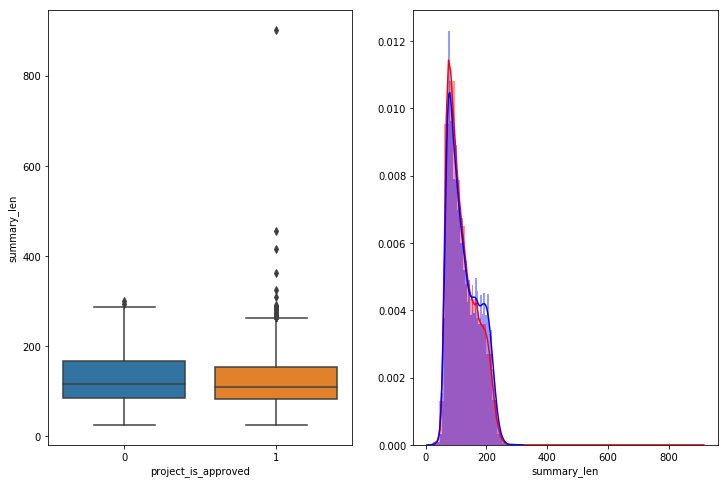

In [177]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.boxplot(x = 'project_is_approved', y = "summary_len", data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['project_is_approved'] == 1.0]["summary_len"][0:] , label = "1", color = 'red')
sns.distplot(df[df['project_is_approved'] == 0.0]["summary_len"][0:] , label = "0" , color = 'blue' )
plt.show()

In [ ]:
##Total essays combined

In [178]:
df['essaytext'] = df.apply(lambda row: ' '.join([str(row['project_essay_1']), 
                                            str(row['project_essay_2']),]), axis=1)

In [180]:
df['char_count'] = df['essaytext'].apply(len)
df['word_count'] = df['essaytext'].apply(lambda x: len(x.split()))
df['word_density'] = df['char_count'] / (df['word_count']+1)
df['punctuation_count'] = df['essaytext'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
df['title_word_count'] = df['essaytext'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
df['upper_case_word_count'] = df['essaytext'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
df['stopword_count'] = df['essaytext'].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stop]))

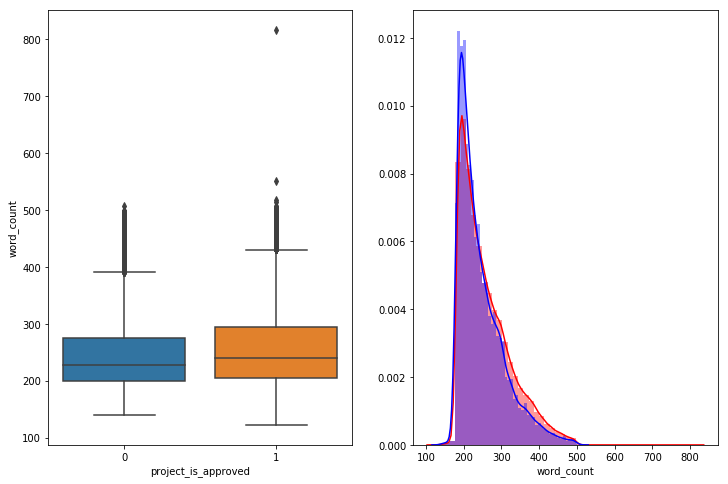

In [181]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.boxplot(x = 'project_is_approved', y = "word_count", data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['project_is_approved'] == 1.0]["word_count"][0:] , label = "1", color = 'red')
sns.distplot(df[df['project_is_approved'] == 0.0]["word_count"][0:] , label = "0" , color = 'blue' )
plt.show()

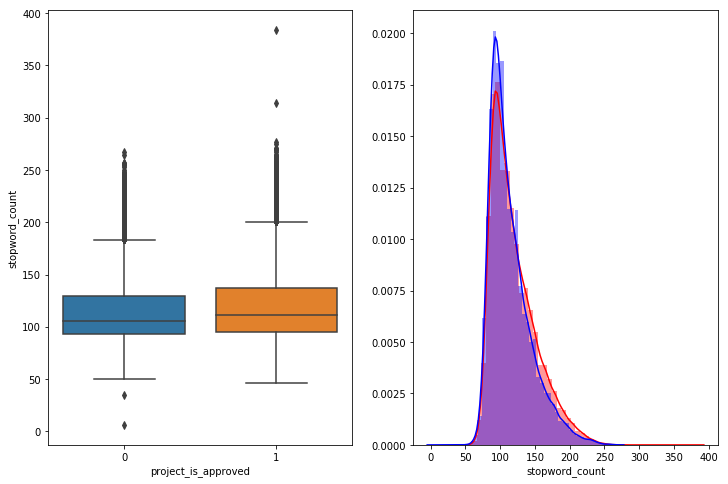

In [182]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.boxplot(x = 'project_is_approved', y = "stopword_count", data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['project_is_approved'] == 1.0]["stopword_count"][0:] , label = "1", color = 'red')
sns.distplot(df[df['project_is_approved'] == 0.0]["stopword_count"][0:] , label = "0" , color = 'blue' )
plt.show()

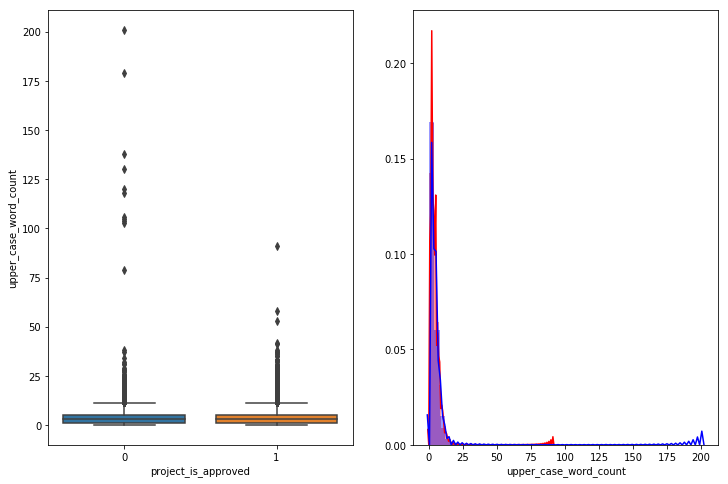

In [183]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.boxplot(x = 'project_is_approved', y = "upper_case_word_count", data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['project_is_approved'] == 1.0]["upper_case_word_count"][0:] , label = "1", color = 'red')
sns.distplot(df[df['project_is_approved'] == 0.0]["upper_case_word_count"][0:] , label = "0" , color = 'blue' )
plt.show()

In [184]:
##Again,The distributions are not very different,still we keep the features

In [186]:
##Words may be common here between project 1 and project2.Can we use fuzzy features?
# No of spelling mistakes might be an important feature.But that takes a lot of time

Sentiment Analysis

In [187]:
#We are using Textblob for sentiment polarity
#Textblob might give us interesting features on the using semantic analysis on essays 

In [188]:
def getpolarity(s):
    sent = TextBlob(s).sentiment
    return sent.polarity
def  getsubjectivity(s):
    sent = TextBlob(s).sentiment
    return sent.subjectivity

In [189]:
textColumns = ['project_essay_1', 'project_essay_2', 'project_resource_summary', 'resource_description', 'project_title']

for col in textColumns:
    df[col+'_polarity'] = df[col].apply(lambda x: getpolarity(x))
    df[col+'_subjectivity'] = df[col].apply(lambda x: getsubjectivity(x))
    

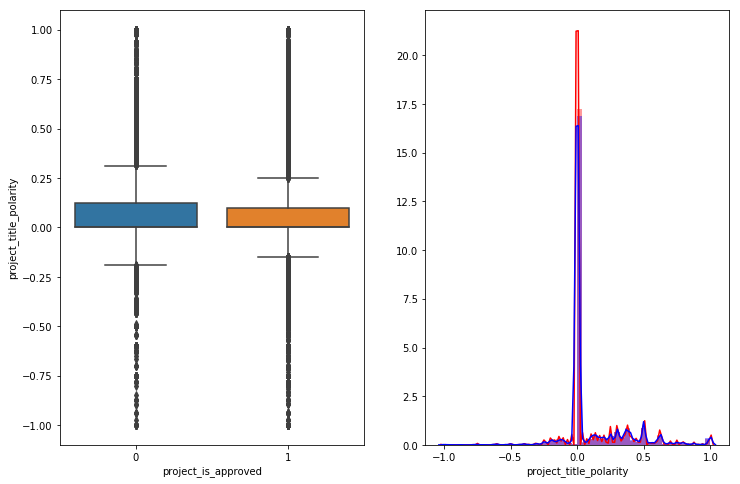

In [190]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.boxplot(x = 'project_is_approved', y = "project_title_polarity", data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['project_is_approved'] == 1.0]["project_title_polarity"][0:] , label = "1", color = 'red')
sns.distplot(df[df['project_is_approved'] == 0.0]["project_title_polarity"][0:] , label = "0" , color = 'blue' )
plt.show()

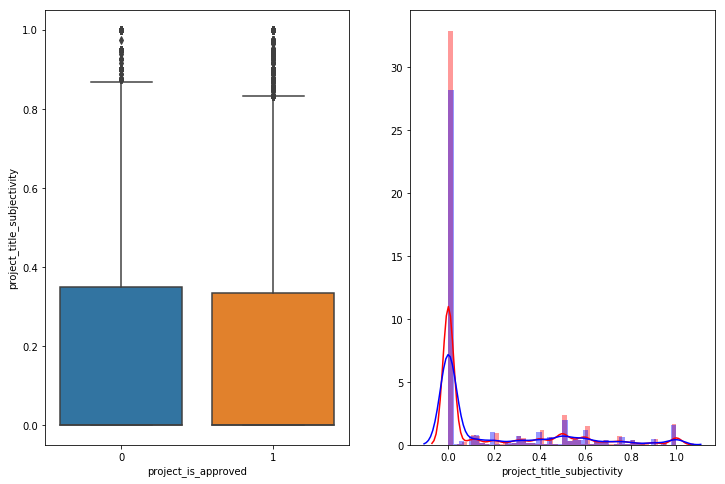

In [191]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.boxplot(x = 'project_is_approved', y = "project_title_subjectivity", data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['project_is_approved'] == 1.0]["project_title_subjectivity"][0:] , label = "1", color = 'red')
sns.distplot(df[df['project_is_approved'] == 0.0]["project_title_subjectivity"][0:] , label = "0" , color = 'blue' )
plt.show()

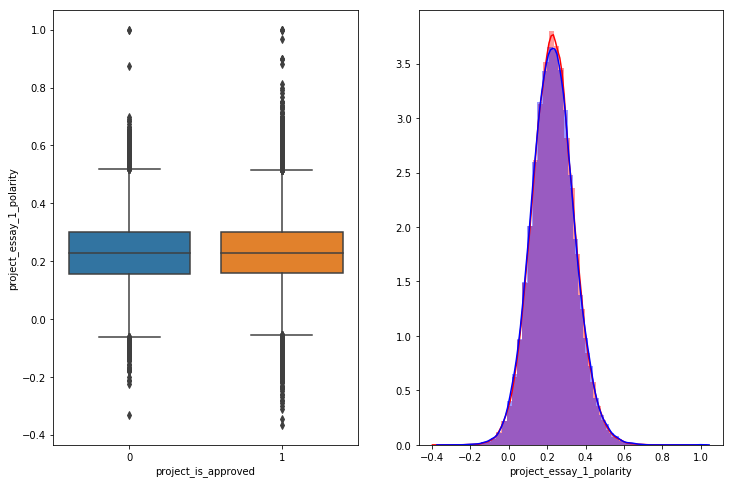

In [192]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.boxplot(x = 'project_is_approved', y = "project_essay_1_polarity", data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['project_is_approved'] == 1.0]["project_essay_1_polarity"][0:] , label = "1", color = 'red')
sns.distplot(df[df['project_is_approved'] == 0.0]["project_essay_1_polarity"][0:] , label = "0" , color = 'blue' )
plt.show()

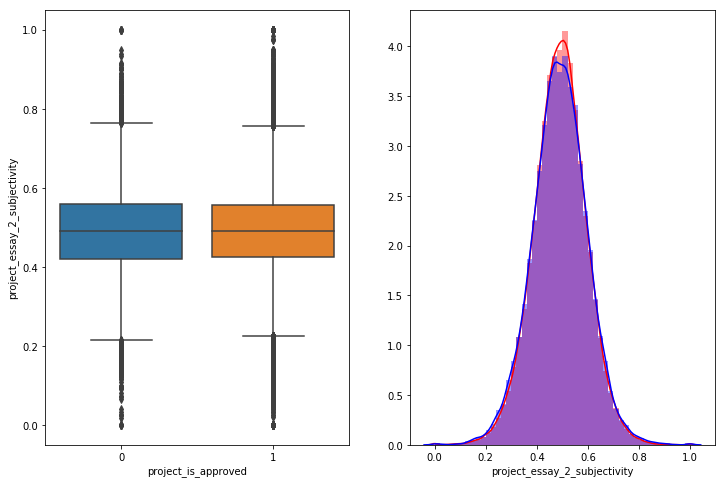

In [193]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.boxplot(x = 'project_is_approved', y = "project_essay_2_subjectivity", data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['project_is_approved'] == 1.0]["project_essay_2_subjectivity"][0:] , label = "1", color = 'red')
sns.distplot(df[df['project_is_approved'] == 0.0]["project_essay_2_subjectivity"][0:] , label = "0" , color = 'blue' )
plt.show()

In [194]:
##Common words if more might lead to rejection

In [195]:
df['commonwords'] = df.apply(lambda x:len(set(str(x['text0'].split())).intersection(str(x["text1"].split()))), axis=1)
        

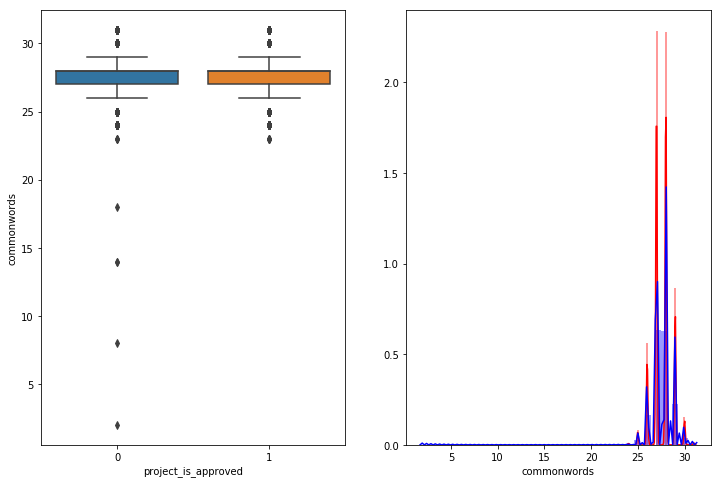

In [196]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.boxplot(x = 'project_is_approved', y = "commonwords", data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['project_is_approved'] == 1.0]["commonwords"][0:] , label = "1", color = 'red')
sns.distplot(df[df['project_is_approved'] == 0.0]["commonwords"][0:] , label = "0" , color = 'blue' )
plt.show()

In [197]:
df.columns

Index(['id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'Year', 'Month', 'Weekday', 'Hour', 'Month_Day', 'Year_Day', 'items',
       'quantity', 'price', 'total_price', 'min_quantity', 'min_price',
       'min_total_price', 'max_quantity', 'max_price', 'max_total_price',
       'mean_quantity', 'mean_price', 'mean_total_price',
       'resource_description', 'text0', 'text1', 'text2', 'text3', 'text4',
       'essay1_len', 'essay2_len', 'title_len', 'resouce_len', 'summary_len',
       'essaytext', 'char_count', 'word_count', 'word_density',
       'punctuation_count', 'title_word_count', 'upper_case_word_count',
       'stopword_count', 'project_essay_1_polarity',
      

In [198]:
Df=df.drop(['id','teacher_id', 'teacher_prefix', 'school_state','project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_resource_summary','project_is_approved','resource_description','essaytext', 'text0',
       'text1', 'text2', 'text3', 'text4'],axis=1)

In [199]:
Df.columns

Index(['teacher_number_of_previously_posted_projects', 'Year', 'Month',
       'Weekday', 'Hour', 'Month_Day', 'Year_Day', 'items', 'quantity',
       'price', 'total_price', 'min_quantity', 'min_price', 'min_total_price',
       'max_quantity', 'max_price', 'max_total_price', 'mean_quantity',
       'mean_price', 'mean_total_price', 'essay1_len', 'essay2_len',
       'title_len', 'resouce_len', 'summary_len', 'char_count', 'word_count',
       'word_density', 'punctuation_count', 'title_word_count',
       'upper_case_word_count', 'stopword_count', 'project_essay_1_polarity',
       'project_essay_1_subjectivity', 'project_essay_2_polarity',
       'project_essay_2_subjectivity', 'project_resource_summary_polarity',
       'project_resource_summary_subjectivity',
       'resource_description_polarity', 'resource_description_subjectivity',
       'project_title_polarity', 'project_title_subjectivity', 'commonwords'],
      dtype='object')

In [200]:
Df.head()

,teacher_number_of_previously_posted_projects,Year,Month,Weekday,Hour,Month_Day,Year_Day,items,quantity,price,...,project_essay_1_subjectivity,project_essay_2_polarity,project_essay_2_subjectivity,project_resource_summary_polarity,project_resource_summary_subjectivity,resource_description_polarity,resource_description_subjectivity,project_title_polarity,project_title_subjectivity,commonwords
128730,30,2016,4,2,0,27,118,1,4,149.00,...,0.485195,0.131503,0.350726,0.000000,0.000000,0.433333,0.833333,0.0,0.00,28
173035,1,2016,4,2,0,27,118,10,10,287.86,...,0.480839,0.185539,0.485948,0.000000,0.000000,-0.075000,0.212500,0.0,0.00,27
7344,8,2016,4,2,0,27,118,7,20,193.93,...,0.472509,0.097898,0.469697,0.044444,0.333333,0.100000,0.700000,-0.1,0.45,27
180523,0,2016,4,2,0,27,118,2,4,256.40,...,0.522470,0.210938,0.510938,0.000000,0.000000,0.095238,0.435714,0.0,0.00,27
8393,53,2016,4,2,0,27,118,4,4,725.05,...,0.600000,0.270549,0.472857,0.200000,0.900000,0.100000,0.400000,0.4,0.50,29


In [201]:
Dftrain=Df.iloc[0:116532,:]
Dfcv=Df.iloc[116532:145664,:]
Dftest=Df.iloc[145664:,:]

In [202]:
Dftrain=np.array(Dftrain)
Dfcv=np.array(Dfcv)
Dftest=np.array(Dftest)


In [203]:
type(Df)

pandas.core.frame.DataFrame

In [204]:
##stacking all the features leaving id and teacher id

In [210]:
FullXcv=hstack((Xtextcv,Dfcv,catcv))
FullXtest=hstack((Xtexttest,Dftest,cattest))
FullXtrain=hstack((Xtexttrain,Dftrain,cattrain))

In [168]:
alpha = [10 ** j for j in range(-5, 2)] # hyperparam for SGD classifier.

cv_auc_array=[]
for i in alpha:
    clf = LogisticRegression(C=i, penalty='l2', random_state=42,class_weight='balanced')
    clf.fit(FullXctrain, y_train)
    predict_y = clf.predict_proba(FullXcv)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_cv,predict_y )
    cv_auc_array.append(metrics.auc(fpr, tpr))
    print('For values of alpha = ', i, "The AUC is:",metrics.auc(fpr, tpr))


For values of alpha =  1e-05 The AUC is: 0.7111915089600188
For values of alpha =  0.0001 The AUC is: 0.7112182265546357
For values of alpha =  0.001 The AUC is: 0.7114543048134325
For values of alpha =  0.01 The AUC is: 0.7136743708516345
For values of alpha =  0.1 The AUC is: 0.7269134585740733
For values of alpha =  1 The AUC is: 0.7437014411845418
For values of alpha =  10 The AUC is: 0.7161183557780552


In [169]:
clf =LogisticRegression(C=1, penalty='l2', random_state=42,class_weight='balanced')
clf.fit(FullXctrain, y_train)

predict_y = clf.predict_proba(FullXctrain)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_train,predict_y )
print('For values of best alpha = ',"The train AUC is:",metrics.auc(fpr, tpr))

predict_y = clf.predict_proba(FullXcv)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_cv,predict_y )
print('For values of best alpha = ', "The cv AUC is:",metrics.auc(fpr, tpr))

predict_y = clf.predict_proba(FullXtest)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,predict_y )
print('For values of best alpha = ', "The test AUC is:",metrics.auc(fpr, tpr))


For values of best alpha =  The train AUC is: 0.8482508216069933
For values of best alpha =  The cv AUC is: 0.7437014411845418
For values of best alpha =  The test AUC is: 0.7575482012072945


In [ ]:
##only 1% improvement

In [220]:
Df.columns

Index(['teacher_number_of_previously_posted_projects', 'Year', 'Month',
       'Weekday', 'Hour', 'Month_Day', 'Year_Day', 'items', 'quantity',
       'price', 'total_price', 'min_quantity', 'min_price', 'min_total_price',
       'max_quantity', 'max_price', 'max_total_price', 'mean_quantity',
       'mean_price', 'mean_total_price', 'essay1_len', 'essay2_len',
       'title_len', 'resouce_len', 'summary_len', 'char_count', 'word_count',
       'word_density', 'punctuation_count', 'title_word_count',
       'upper_case_word_count', 'stopword_count', 'project_essay_1_polarity',
       'project_essay_1_subjectivity', 'project_essay_2_polarity',
       'project_essay_2_subjectivity', 'project_resource_summary_polarity',
       'project_resource_summary_subjectivity',
       'resource_description_polarity', 'resource_description_subjectivity',
       'project_title_polarity', 'project_title_subjectivity', 'commonwords'],
      dtype='object')

In [222]:
#DF=Df.drop(['Year', 'Month','Weekday', 'Hour', 'Month_Day', 'Year_Day',],axis=1)

In [214]:
##When I applied SGD with loss=log ,the results were poor again.Why?with logistic they are good!
#Same with SVM here

In [224]:
alpha = [10 ** j for j in range(-5, 1)] # hyperparam for SGD classifier.

cv_auc_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i,loss='hinge', penalty='l2', random_state=42)
    clf.fit(FullXtrain, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(FullXtrain, y_train)
    predict_y = sig_clf.predict_proba(FullXcv)[:,1]
    
    fpr, tpr, thresholds = metrics.roc_curve(y_cv,predict_y )
    cv_auc_array.append(metrics.auc(fpr, tpr))
    print('For values of alpha = ', i, "The AUC is:",metrics.auc(fpr, tpr))

For values of alpha =  1e-05 The AUC is: 0.5
For values of alpha =  0.0001 The AUC is: 0.6580257682702118
For values of alpha =  0.001 The AUC is: 0.6591284930414214
For values of alpha =  0.01 The AUC is: 0.6527291872365922
For values of alpha =  0.1 The AUC is: 0.6673437600518759
For values of alpha =  1 The AUC is: 0.6612107949648862


In [226]:

alpha = [10 ** j for j in range(-5, 1)] # hyperparam for SGD classifier.

cv_auc_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2',loss='log', random_state=42,class_weight='balanced')
    clf.fit(FullXtrain, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(FullXtrain, y_train)
    predict_y = sig_clf.predict_proba(FullXcv)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_cv,predict_y )
    cv_auc_array.append(metrics.auc(fpr, tpr))
    print('For values of alpha = ', i, "The AUC is:",metrics.auc(fpr, tpr))


For values of alpha =  1e-05 The AUC is: 0.5
For values of alpha =  0.0001 The AUC is: 0.5
For values of alpha =  0.001 The AUC is: 0.6450613832608744
For values of alpha =  0.01 The AUC is: 0.6389187936241699
For values of alpha =  0.1 The AUC is: 0.6677314808124355
For values of alpha =  1 The AUC is: 0.6687939980802957


In [ ]:
## Why SGD with loss-log is not giving good results?

In [208]:
import xgboost as xgb

In [215]:
params_xgb = {
        'eta': 0.02,
        'max_depth': 4,
        'subsample': 0.85,
        'colsample_bytree': 0.25,
        'min_child_weight': 3,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'seed': 0,
        'silent': 1,
    }
dtrain = xgb.DMatrix(FullXtrain, label=y_train)
dval   = xgb.DMatrix(FullXtest, label=y_test)
watchlist = [(dtrain, 'train'), (dval, 'valid')]
model = xgb.train(params_xgb, dtrain, 5000,  watchlist, maximize=True, verbose_eval=200, early_stopping_rounds=200)
Yvl1 = model.predict(dval)
Yts1 = model.predict(xgb.DMatrix(FullXtest)) 

[0]	train-auc:0.659326	valid-auc:0.649136
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 200 rounds.
[200]	train-auc:0.754789	valid-auc:0.743542
[400]	train-auc:0.77957	valid-auc:0.759845
[600]	train-auc:0.79414	valid-auc:0.767805
[800]	train-auc:0.80502	valid-auc:0.772852
[1000]	train-auc:0.813585	valid-auc:0.776452
[1200]	train-auc:0.821014	valid-auc:0.779054
[1400]	train-auc:0.827522	valid-auc:0.781159
[1600]	train-auc:0.833378	valid-auc:0.782746
[1800]	train-auc:0.838679	valid-auc:0.784195
[2000]	train-auc:0.843436	valid-auc:0.785108
[2200]	train-auc:0.847659	valid-auc:0.786207
[2400]	train-auc:0.85173	valid-auc:0.786941
[2600]	train-auc:0.855605	valid-auc:0.787534
[2800]	train-auc:0.85933	valid-auc:0.788185
[3000]	train-auc:0.862808	valid-auc:0.788827
[3200]	train-auc:0.866025	valid-auc:0.788975
[3400]	train-auc:0.869142	valid-auc:0.78915
[3600]	train-auc:0.872097	valid-auc:0.789326
[3800]	train-a

In [ ]:
##By Xgboost we are achieving the best

In [ ]:
##Not doing random/grid search  because that will take a lot of time
#just took random nos from kaggle and it achieved more better!

In [181]:
import xgboost as xgb

In [411]:
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,4],
    'colsample_bytree':[0.1,0.3,0.5],
    'subsample':[0.1,0.3,0.5]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl.fit(FulXtrain, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 43.0min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 67.7min remaining:  7.5min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 100.1min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'learning_rate': [0.01, 0.03, 0.05, 0.1], 'n_estimators': [100, 200, 500, 1000, 2000], 'max_depth': [3, 4], 'colsample_bytree': [0.1, 0.3, 0.5], 'subsample': [0.1, 0.3, 0.5]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=10)

In [412]:
random_cfl.best_params_

{'subsample': 0.3,
 'n_estimators': 2000,
 'max_depth': 4,
 'learning_rate': 0.03,
 'colsample_bytree': 0.5}

In [418]:
x_cfl=XGBClassifier(n_estimators=2000,max_depth=4,learning_rate=0.03,colsample_bytree=0.5,subsample=1,nthread=-1)
x_cfl.fit(FulXtrain,y_train,verbose=True)


predict_y =x_cfl.predict_proba(FulXtrain)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_train,predict_y )
print('For values of best alpha = ',"The train AUC is:",metrics.auc(fpr, tpr))

predict_y = x_cfl.predict_proba(FulXcv)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_cv,predict_y )
print('For values of best alpha = ', "The cv AUC is:",metrics.auc(fpr, tpr))

predict_y =x_cfl.predict_proba(FulXtest)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,predict_y )
print('For values of best alpha = ', "The test AUC is:",metrics.auc(fpr, tpr))


For values of best alpha =  The train AUC is: 0.8686534215544958
For values of best alpha =  The cv AUC is: 0.7739730828829317
For values of best alpha =  The test AUC is: 0.7861557808580972


In [217]:
import lightgbm as lgb

In [218]:
params = {
         'boosting_type': 'gbdt',
         'objective': 'binary',
         'metric': 'auc',
         'max_depth': 16,
         'num_leaves': 31,
         'learning_rate': 0.025,
         'feature_fraction': 0.85,
         'bagging_fraction': 0.85,
         'bagging_freq': 5,
         'verbose': 0,
         'num_threads': 1,
         'lambda_l2': 1,
         'min_gain_to_split': 0,
         }  

model2 = lgb.train(
    params,
    lgb.Dataset(FullXtrain, y_train),
    num_boost_round=10000,
    valid_sets=[lgb.Dataset(FullXtest, y_test)],
    verbose_eval=100,
    early_stopping_rounds=100
    )

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.752475
[200]	valid_0's auc: 0.770263
[300]	valid_0's auc: 0.779336
[400]	valid_0's auc: 0.783714
[500]	valid_0's auc: 0.786323
[600]	valid_0's auc: 0.788048
[700]	valid_0's auc: 0.788819
[800]	valid_0's auc: 0.789379
[900]	valid_0's auc: 0.789793
[1000]	valid_0's auc: 0.789967
[1100]	valid_0's auc: 0.790262
[1200]	valid_0's auc: 0.790514
[1300]	valid_0's auc: 0.790656
[1400]	valid_0's auc: 0.790882
Early stopping, best iteration is:
[1356]	valid_0's auc: 0.790949


In [219]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': 35,
    #'num_leaves': 500,
    'learning_rate': 0.01,
    'feature_fraction': 0.80,
    'bagging_fraction': 0.80,
    'bagging_freq': 5,
    'max_bin':300,
    #'verbose': 0,
    #'num_threads': 1,
    'lambda_l2': 1.5,
    #'min_gain_to_split': 0,
    'is_unbalance': True
    #'scale_pos_weight':0.15
}  

# LGBM dataset
model2 = lgb.train(
    lgbm_params,
    lgb.Dataset(FullXtrain, y_train),
    num_boost_round=10000,
    valid_sets=[lgb.Dataset(FullXtest, y_test)],
    verbose_eval=100,
    early_stopping_rounds=100
    )

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.743831
[200]	valid_0's auc: 0.754731
[300]	valid_0's auc: 0.764028
[400]	valid_0's auc: 0.770393
[500]	valid_0's auc: 0.775301
[600]	valid_0's auc: 0.779191
[700]	valid_0's auc: 0.781981
[800]	valid_0's auc: 0.784454
[900]	valid_0's auc: 0.786363
[1000]	valid_0's auc: 0.787832
[1100]	valid_0's auc: 0.788874
[1200]	valid_0's auc: 0.789786
[1300]	valid_0's auc: 0.790485
[1400]	valid_0's auc: 0.790986
[1500]	valid_0's auc: 0.791442
[1600]	valid_0's auc: 0.791853
[1700]	valid_0's auc: 0.792065
[1800]	valid_0's auc: 0.792304
[1900]	valid_0's auc: 0.79243
[2000]	valid_0's auc: 0.792728
[2100]	valid_0's auc: 0.792951
[2200]	valid_0's auc: 0.793041
[2300]	valid_0's auc: 0.793243
[2400]	valid_0's auc: 0.793399
Early stopping, best iteration is:
[2366]	valid_0's auc: 0.793438


In [ ]:
##0.793 is best out of LGBM

In [ ]:
###furthur work:
1.Fuzzy features might be useful(essays might mean the same)
2.Spelling mistakes for both preprocessing and feature extraction
3.Random/grid search for xgboost
4.Stemming can prove to be useful
